# Investigation of complex and non-spatial sequences

In [1]:
%matplotlib inline
from copy import deepcopy as copy
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from aux import sgmd, Generic
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks

## Ntwk smln

In [2]:
class SimpleNtwk(object):
    """Simplified network model."""
    
    def __init__(self, w, ltp_ie, max_active, v_th, rp):
        
        assert w.shape[0] == w.shape[1]
        assert len(ltp_ie) == w.shape[0]
        assert v_th > 0
        assert max_active <= w.shape[0]
        
        self.w = w
        self.ltp_ie = ltp_ie
        self.max_active = max_active
        self.v_th = v_th
        self.rp = int(rp)
        
        self.n = w.shape[0]
    
    def run(self, inp_ext, inp_g):
        
        n_t = len(inp_ext)
        
        v = np.zeros((n_t, self.n), dtype=float)
        spks = np.zeros((n_t, self.n), dtype=bool)
        
        rp = np.zeros(self.n, dtype=int)
        
        spks_prev = np.zeros(self.n, dtype=bool)
        
        for t_ctr, inp_ext_ in enumerate(inp_ext):
            
            # compute total inputs
            # (recurrent + g + external)
            v_ = self.w.dot(spks_prev) + inp_g*(1+self.ltp_ie) + inp_ext_
            
            # set nrns in refrac period to 0
            v_[rp > 0] = 0
            
            # decrement refractory period
            rp = np.clip(rp-1, 0, np.inf)
            
            # get tmp variable containing only max_active voltages
            v_max_only = np.zeros(self.n)
            idxs_most_active = np.argsort(v_)[-self.max_active:]
            v_max_only[idxs_most_active] = v_[idxs_most_active]
            
            # convert to spks
            spks_ = v_max_only >= self.v_th
            #spks_ = np.zeros(self.n, dtype=bool)
            #if np.any(v_max_only >= self.v_th):
            #    spks_[idxs_most_active] = True
            
            # reset refractory period for spking nrns
            rp[spks_] = self.rp
            
            # store everything
            v[t_ctr] = v_.copy()
            spks[t_ctr] = spks_.copy()
            spks_prev = spks_.copy()
        
        return Generic(t=np.arange(len(inp_ext)), v=v, spks=spks)

## Complex (self-intersecting) trajectory

### Trajectory

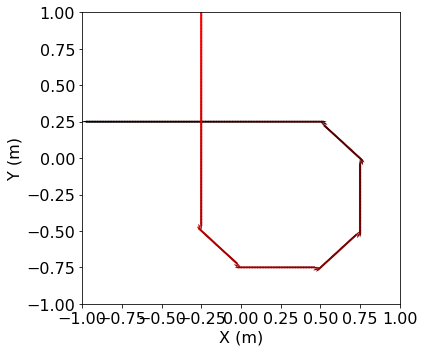

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), tight_layout=True)

x_trj = []
y_trj = []

# E
x_trj.append(np.linspace(-1, .5, 151))
y_trj.append(np.repeat(.25, 151))

# SE
x_trj.append(np.linspace(.5, .75, 36)[1:])
y_trj.append(np.linspace(.25, 0, 36)[1:])

# S
x_trj.append(np.repeat(.75, 51)[1:])
y_trj.append(np.linspace(0, -.5, 51)[1:])

# SW
x_trj.append(np.linspace(.75, .5, 36)[1:])
y_trj.append(np.linspace(-.5, -.75, 36)[1:])

# W
x_trj.append(np.linspace(.5, 0, 51)[1:])
y_trj.append(np.repeat(-.75, 51)[1:])

# NW
x_trj.append(np.linspace(0, -.25, 36)[1:])
y_trj.append(np.linspace(-.75, -.5, 36)[1:])

# N
x_trj.append(np.repeat(-.25, 151)[1:])
y_trj.append(np.linspace(-.5, 1, 151)[1:])

x_trj = np.concatenate(x_trj)
y_trj = np.concatenate(y_trj)

n = len(x_trj)

dx_trj = np.gradient(x_trj)
dy_trj = np.gradient(y_trj)

norm_trj = np.sqrt(dx_trj**2 + dy_trj**2)
dx_trj /= norm_trj
dy_trj /= norm_trj

tht_trj = np.arctan2(dy_trj, dx_trj)

ax.quiver(
    x_trj, y_trj, dx_trj, dy_trj,
    color=np.transpose([np.linspace(0, 1, n), np.zeros(n), np.zeros(n)]))

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

set_font_size(ax, 16)

### Network

In [4]:
# function for plotting oriented triangles
def get_tri_coord(x, y, tht, b, h):
    """Return coordinates of rotated triangle."""
    # get coords w/ upper left corner at origin
    xy = np.array([[0, 0], [0, -b], [h, -b/2]])
    
    # put center of mass at origin
    c_x = xy[:, 0].mean()
    c_y = xy[:, 1].mean()
    xy[:, 0] -= c_x
    xy[:, 1] -= c_y
    
    # rotate
    r = np.array([[np.cos(tht), -np.sin(tht)], [np.sin(tht), np.cos(tht)]])
    xy = np.dot(xy, r.T)
    
    # shift
    xy[:, 0] += x
    xy[:, 1] += y
    
    return xy


def tri_scatter(ax, x, y, tht, c, b, h):
    """Make scatter plot of oriented triangles."""
    polys = [
        Polygon(get_tri_coord(x_, y_, tht_, b, h), zorder=tht_)
        for x_, y_, tht_ in zip(x, y, tht)
    ]
    
    ax.add_collection(PatchCollection(polys, color=c))
    
    return ax

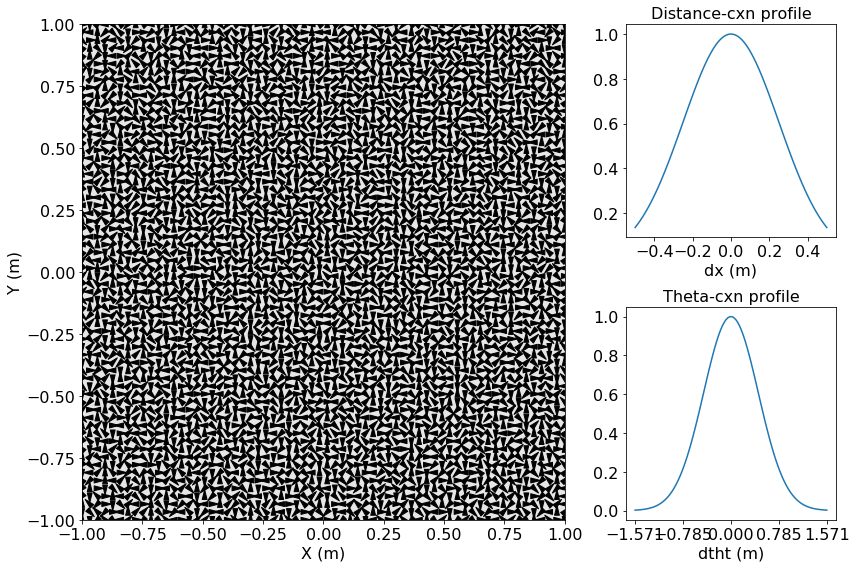

In [5]:
# network architecture
np.random.seed(0)
N_X = 64
N_Y = 64
N = N_X*N_Y
N_THT = 8

L_XY_W = .25
L_THT_W = np.pi/7

# build grid representation of cells
x_, y_ = np.meshgrid(np.linspace(-1, 1, N_X), np.linspace(-1, 1, N_Y), indexing='xy')

tht_ = np.nan * np.zeros((N_X, N_Y))
for r_ctr in range(N_Y):
    tht_row = np.concatenate([
        (np.random.permutation(N_THT) - (N_THT/2)) * 2*np.pi/N_THT
        for ctr in range(int(N_X/N_THT))
    ])
    tht_[r_ctr, :] = copy(tht_row)
    
x = x_.flatten()
y = y_.flatten()
tht = tht_.flatten()


gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(12, 8), tight_layout=True)
axs = []
axs.append(fig.add_subplot(gs[:, :2]))
axs.append(fig.add_subplot(gs[0, 2]))
axs.append(fig.add_subplot(gs[1, 2]))

# show distribution of place/theta tunings
tri_scatter(axs[0], x, y, tht, N_X*N_Y*['k'], .02, .04)
axs[0].set_xlim(-1, 1)
axs[0].set_ylim(-1, 1)
axs[0].set_facecolor((.9, .9, .9))
axs[0].set_xlabel('X (m)')
axs[0].set_ylabel('Y (m)')

# show connectivity profiles
## x, y
d_l_xy_w = np.linspace(-.5, .5, 100)
axs[1].plot(d_l_xy_w, np.exp(-(d_l_xy_w**2)/(2*L_XY_W**2)))
axs[1].set_xlabel('dx (m)')
axs[1].set_title('Distance-cxn profile')

## tht
tht_l_tht_w = np.linspace(-np.pi/2, np.pi/2, 100)
axs[2].plot(tht_l_tht_w, np.exp(-(tht_l_tht_w**2)/(2*L_THT_W**2)))
axs[2].set_xticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])
axs[2].set_xlabel('dtht (m)')
axs[2].set_title('Theta-cxn profile')

for ax in axs:
    set_font_size(ax, 16)

Connectivity matrix:

$
w(\Delta x, \Delta y, \Delta \theta) = 
\exp\left(-\cfrac{\Delta x^2 + \Delta y^2}{2\lambda_{xy}^2}\right)
\exp\left(-\cfrac{\Delta \theta^2}{2\lambda_\theta}\right)
$

In [6]:
# build connectivity matrix
x_ = np.tile(x[:, None], (1, len(x)))
y_ = np.tile(y[:, None], (1, len(y)))
tht_ = np.tile(tht[:, None], (1, len(tht)))

dx = x_ - x_.T
dy = y_ - y_.T
dtht = np.min(np.array([
    np.abs(tht_ - tht_.T),
    np.abs(tht_ - tht_.T + 2*np.pi),
    np.abs(tht_ - tht_.T - 2*np.pi),
]), axis=0)

w = np.exp(-(dx**2 + dy**2)/(2*L_XY_W**2)) * np.exp(-(dtht**2)/(2*L_THT_W**2))

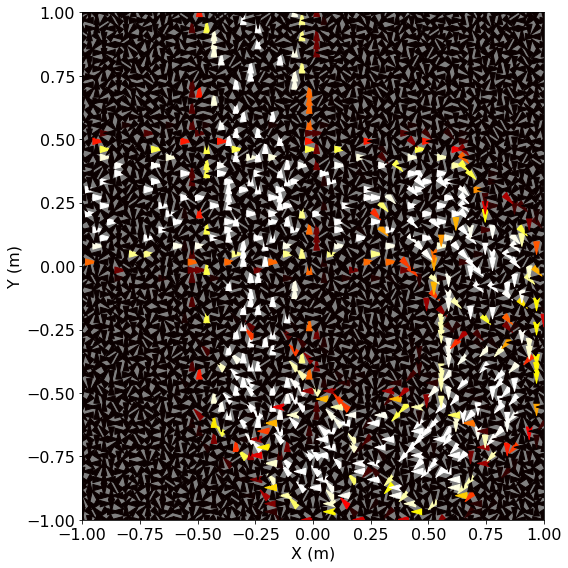

In [7]:
# construct LTP-IE profile
L_X = .2
L_Y = .2
L_THT = np.pi/16
BETA = 20


def calc_ltp_ie(x, y, tht, x_0, y_0, tht_0, l_x, l_y, l_tht, beta):
    """Return LTP-IE strength for location/angle (x_0, y_0, th_0)."""
    dx_2 = ((x - x_0)**2)/(2*l_x**2)
    dy_2 = ((y - y_0)**2)/(2*l_y**2)
    dtht = np.min(np.array([
        np.abs(tht - tht_0),
        np.abs(tht - tht_0 + 2*np.pi),
        np.abs(tht - tht_0 - 2*np.pi),
    ]), axis=0)
    dtht_2 = (dtht**2)/(2*l_tht**2)
    exponent = -(dx_2 + dy_2 + dtht_2)
    return sgmd(beta * (np.exp(exponent) - 0.5))


ltp_ie = np.nan * np.zeros(len(x))
for x_0, y_0, tht_0 in zip(x_trj, y_trj, tht_trj):
    
    ltp_ie_tmp = calc_ltp_ie(
        x, y, tht, x_0, y_0, tht_0, L_X, L_Y, L_THT, BETA)
    
    ltp_ie = np.nanmax(np.array([ltp_ie, ltp_ie_tmp]), axis=0)


# make quiver plot of x, y, tht_, colored by LTP-IE
cmap = cm.get_cmap('hot')
colors = cmap(ltp_ie)
fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
tri_scatter(ax, x, y, tht, colors, .025, .05)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_facecolor((.5, .5, .5))
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
set_font_size(ax, 16)

In [10]:
# run smln in forward
## build ntwk
ntwk = SimpleNtwk(w=w, ltp_ie=ltp_ie, max_active=10, v_th=11, rp=6)

## build stim
t_smln = 50
inp_g = 5  ### bkgd yielding LTP-IE differentiated baseline

inp_ext = np.zeros((t_smln, N))  ### triggering stim

### give sqexp input decaying from trigger focus
x_trg = -1
y_trg = .25
l_trg = .2
a_trg = 3

d_trg = np.sqrt((x-x_trg)**2 + (y-y_trg)**2)
### add single timestep trigger input
inp_ext[1, :] = a_trg*np.exp(-(d_trg)**2 / (2*l_trg**2))

## run smln
rslt = ntwk.run(inp_ext, inp_g)

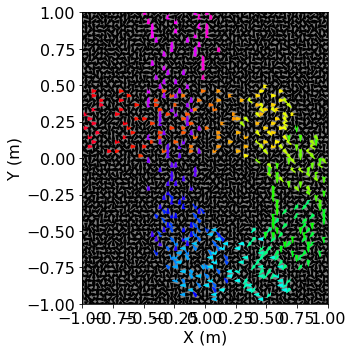

In [11]:
# plot spike order
cmap = cm.get_cmap('gist_rainbow')

spk_order = np.nan * np.zeros(N)
for n_ctr in range(N):
    if np.any(rslt.spks[:, n_ctr]):
        spk_order[n_ctr] = np.nonzero(rslt.spks[:, n_ctr])[0][0]

# normalize spk_order
spk_order -= np.nanmin(spk_order)
spk_order /= np.nanmax(spk_order)

colors = []
for spk_order_ in spk_order:
    if not np.isnan(spk_order_):
        color = cmap(spk_order_)
    else:
        color = 'k'
    colors.append(color)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
tri_scatter(ax, x, y, tht, colors, .02, .04)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_facecolor((.5, .5, .5))
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

set_font_size(ax, 16)